## Import Libraries

In [1]:
from keras import layers
from keras import models
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import numpy as np
from livelossplot.inputs.tf_keras import PlotLossesCallback
from IPython.display import Image
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Generate Training, Validation and Test Batches

In [2]:
#ImageDataGenerators

#set size of images
img_size = 48

#set batch size
batch_size = 64

#create ImageDataGenerator for training data - split into training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2) 

print("Training set: ")

#training set
train_generator = train_datagen.flow_from_directory(
    "train/",
    target_size=(img_size,img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 

print("\nValidation set: ")

#validation set
validation_generator = train_datagen.flow_from_directory(
    "train/", 
    target_size=(img_size,img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


#create ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

print("\nTest set: ")

#test set
test_generator = test_datagen.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Training set: 
Found 22968 images belonging to 7 classes.

Validation set: 
Found 5741 images belonging to 7 classes.

Test set: 
Found 7178 images belonging to 7 classes.


## Development of CNN

In [3]:
#initialise the model
model = models.Sequential()

#1st convolutional layer
model.add(layers.Conv2D(128,(3,3), activation='relu', input_shape=(48,48,1), padding='same'))
model.add(BatchNormalization())

#2nd convolutional layer
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

#3rd convolutional layer
model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

#4th convolutional layer
model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

#5th convolutional layer
model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

#6th convolutional layer
model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

#7th convolutional layer
model.add(layers.Conv2D(1024,(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

#8th convolutional layer
model.add(layers.Conv2D(1024,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

#flatten
model.add(layers.Flatten())

#fully connected layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))


#dropout layer
model.add(layers.Dropout(0.25))

#activation layer
model.add(layers.Dense(7, activation='softmax'))

#set learning rate for optimizer
opt = Adam(learning_rate=0.0005)

#compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#view model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 128)       512       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 256)       2

# View model architecture

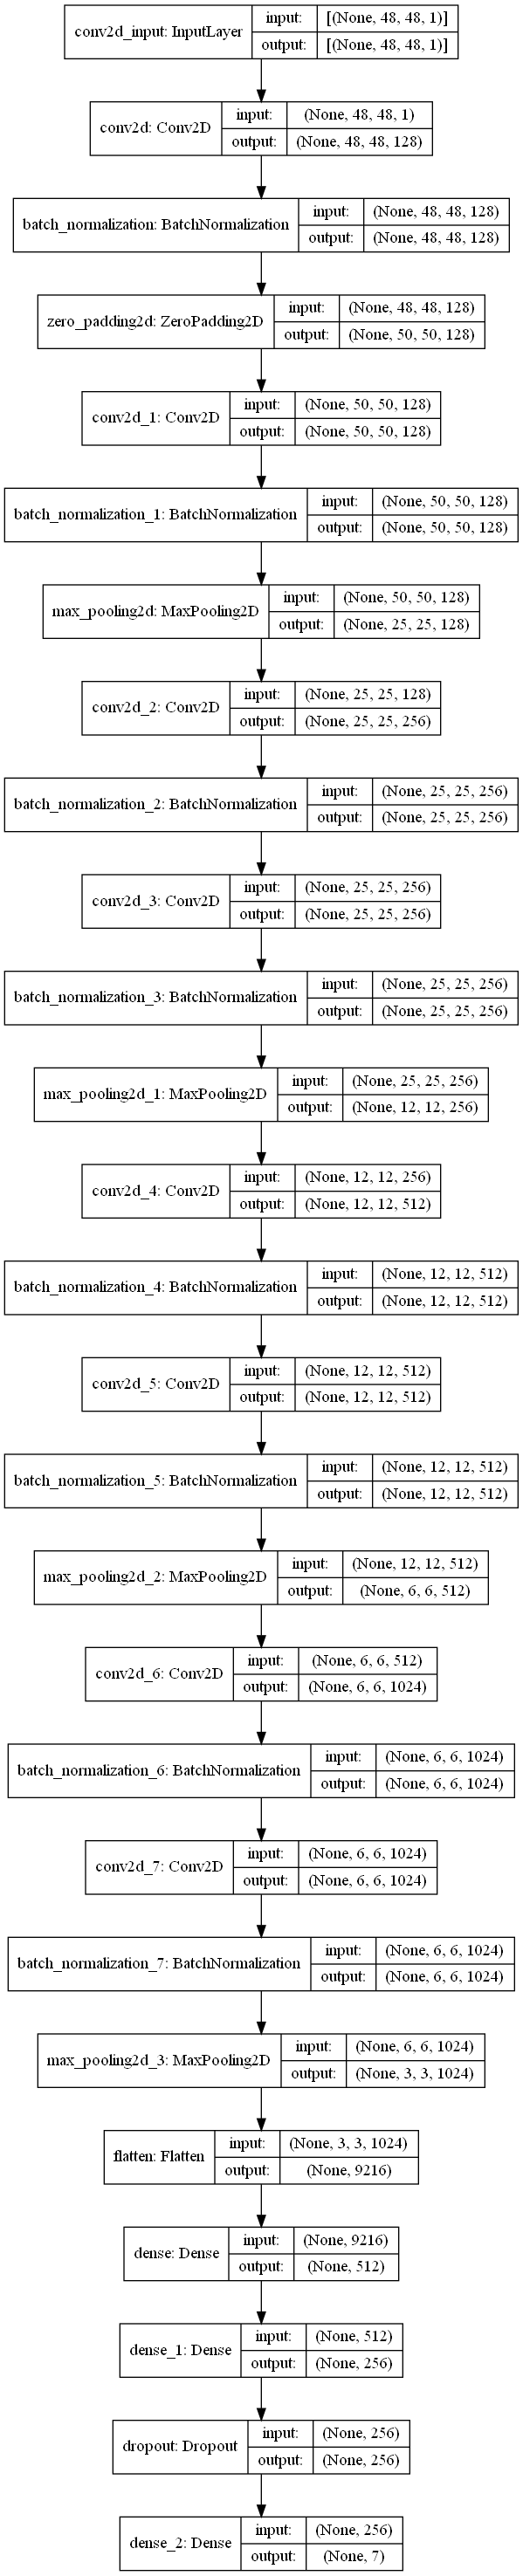

In [4]:
#plot the model and save 
plot_model(model, to_file='model8.png', show_shapes=True, show_layer_names=True)

#display the model
Image('model8.png',width=400, height=200)

# Define parameters for training

In [5]:
#Parameters for model.fit() method

#calculate class weights 
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

class_weights = {i : class_weights[i] for i in range(7)}

# number of epochs
epochs = 100

#calculate the number of steps per epoch for training and validation sets
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#callbacks
#reduce the learning rate if validation loss has not improved for three epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

#save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(filepath="CNN8Layer.h5", monitor='val_accuracy', mode='max',
                             save_best_only=True, verbose=1)

#stop training when the accuracy does not improve for 15 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)

#all callbacks
callbacks = [reduce_lr, model_checkpoint, early_stopping]

print("Class indices: ", train_generator.class_indices)
print("\nClass weights: ")
class_weights

Class indices:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Class weights: 


{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

# Train the CNN

In [7]:
%%time

#train the CNN
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
358/358 [==============================] - 34s 94ms/step - loss: 3.3204 - accuracy: 0.2025 - val_loss: 2.9451 - val_accuracy: 0.2221

Epoch 00001: val_accuracy improved from -inf to 0.22209, saving model to CNN8Layer.h5
Epoch 2/100
358/358 [==============================] - 31s 86ms/step - loss: 2.6183 - accuracy: 0.2942 - val_loss: 2.6410 - val_accuracy: 0.3183

Epoch 00002: val_accuracy improved from 0.22209 to 0.31829, saving model to CNN8Layer.h5
Epoch 3/100
358/358 [==============================] - 31s 85ms/step - loss: 2.1742 - accuracy: 0.3646 - val_loss: 2.0422 - val_accuracy: 0.3715

Epoch 00003: val_accuracy improved from 0.31829 to 0.37149, saving model to CNN8Layer.h5
Epoch 4/100
358/358 [==============================] - 31s 85ms/step - loss: 1.8996 - accuracy: 0.3976 - val_loss: 1.6891 - val_accuracy: 0.4556

Epoch 00004: val_accuracy improved from 0.37149 to 0.45558, saving model to CNN8Layer.h5
Epoch 5/100
358/358 [==============================] - 31s 86ms

# Plot accuracy and loss graphs

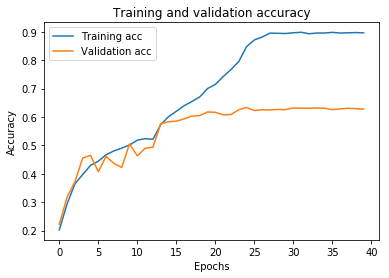

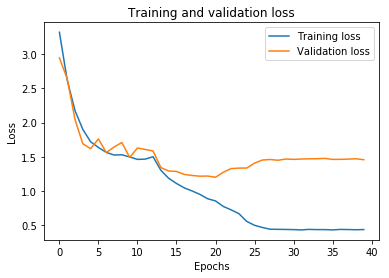

In [8]:
#get accuracy and loss values
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

#number of epochs
epochs = range(len(acc))

#set accuracy graph details
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#set loss graph details
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#display the graphs
plt.show()

# Test the CNN

In [9]:
#load the best saved model
model.load_weights("CNN8Layer.h5")

test_loss, test_acc = model.evaluate(test_generator, steps=112)
print("%s: %.2f%%" % ("Model Accuracy", test_acc*100))

112/112 [==============================] - 5s 47ms/step - loss: 1.3251 - accuracy: 0.6422 1s
Model Accuracy: 64.22%


# Plot confusion matrix

In [10]:
#predictions made by the model
predictions = model.predict(test_generator,  test_generator.n // test_generator.batch_size)

#the predicted class of the image
predicted_classes = np.argmax(predictions, axis=1)

#the true class of the image
true_classes = test_generator.classes

#class labels
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

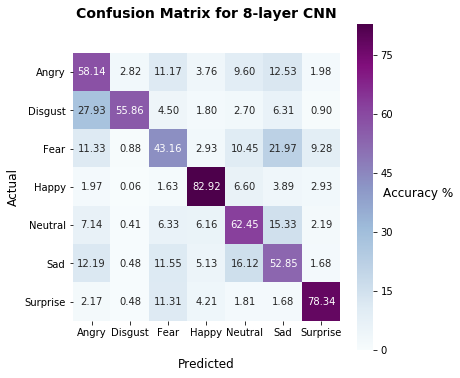

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#confusion matrix of true vs predicted classes
cm = confusion_matrix(true_classes, predicted_classes)

# Normalized confusion matrix, multiplied by 100 for percentages
cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) *100

#create the figure and set the size
fig, ax = plt.subplots(figsize=(6,6))

#create the heatmap
sns.heatmap(cmn, square=True, cmap="BuPu", annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)

#customise the colourbar
cbar = ax.collections[0].colorbar
cbar.set_label("Accuracy %", rotation=0, fontsize=12, labelpad=25)

#set labels, title and plot the normalised confusion matrix
plt.yticks(rotation=0)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12, labelpad=20)
plt.title("Confusion Matrix for 8-layer CNN", weight='bold', fontsize=14, pad=35)
plt.show(block=False)

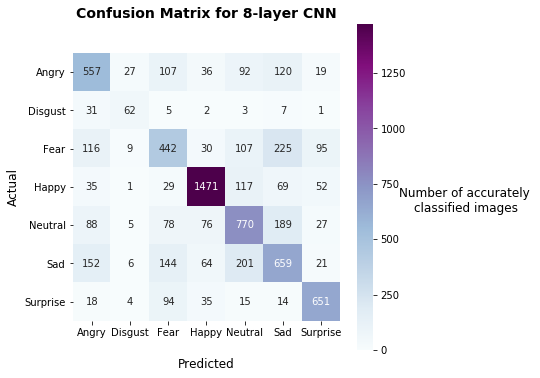

In [12]:
#plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, square=True, cmap="BuPu", annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
cbar = ax.collections[0].colorbar
cbar.set_label("Number of accurately \nclassified images", rotation=0, fontsize=12, labelpad=60)
plt.yticks(rotation=0)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12, labelpad=20)
plt.title("Confusion Matrix for 8-layer CNN", weight='bold', fontsize=14, pad=35)
plt.show()